In [1]:
import os 
import json
import warnings
import re

import numpy as np
import pandas as pd

import matplotlib
from matplotlib import gridspec
import matplotlib.pyplot as plt

import statsmodels.api as sm

import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error


from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import LeaveOneOut

from sklearn.model_selection import ShuffleSplit, KFold


from scipy.stats import pearsonr, spearmanr
from scipy.stats import ttest_1samp

In [2]:
%matplotlib inline
with open('../figures/.rcparams.json', 'r') as fh:
    matplotlib.rcParams.update(json.load(fh))
    
pltdir = '../figures/'
data_dir = '../data'

In [3]:
dataset = pd.read_csv(os.path.join(data_dir,'dataset.csv'), sep=',', index_col=0)

y = dataset.groupby('name').agg({'dG (kcal/mol)': 'first', 'testset': 'first'})

y_train = y.loc[y.testset==0]['dG (kcal/mol)']
y_test = y.loc[y.testset==1]['dG (kcal/mol)']

In [4]:
### vdW

X_vdw = pd.read_csv(os.path.join(data_dir, 'vdw_pairwise.csv'), sep=',', index_col=0).transpose()
X_vdw.drop(X_vdw.columns[np.max(X_vdw.loc[y_train.index], axis=0)>0.], axis=1, inplace=True)
X_vdw.drop(X_vdw.columns[np.mean(np.abs(X_vdw.loc[y_train.index]),axis=0)<0.1], axis=1, inplace=True)
X_vdw.dropna(axis=1, inplace=True)

print('vdw df shape: ' + str(X_vdw.shape))


### electrostatics 

X_elec = pd.read_csv(os.path.join(data_dir, 'elec_pairwise.csv'), sep=',', index_col=0).transpose()
X_elec.drop(X_elec.columns[np.max(X_elec.loc[y_train.index], axis=0)>0.], axis=1, inplace=True)
X_elec.drop(X_elec.columns[np.mean(np.abs(X_elec.loc[y_train.index]),axis=0)<1], axis=1, inplace=True)
X_elec.dropna(axis=1, inplace=True)

print('elec df shape: ' + str(X_elec.shape))


### Sequence

sequence = pd.read_csv(os.path.join(data_dir, 'aa_sequence.csv'), sep=',', index_col=0)
X_mut = (sequence == sequence.loc['01_DRV_6DGX']).astype(int)

print('sequence df shape: ' + str(sequence.shape))


### Split into train and testset

X_mut_train = X_mut.loc[y_train.index]
X_mut.drop(X_mut_train.columns[X_mut_train.sum(axis=0)==X_mut_train.shape[0]], axis=1, inplace=True)


### Merge

X = pd.concat([X_vdw, X_elec], axis=1, sort=False)
X = X.round(5)

print('X df shape: ' + str(X.shape))

### Create combined dataframes for subsequent visulaizations
X_seq = pd.concat([X, sequence], axis=1)

X_train = X.loc[y_train.index]
X_test = X.loc[y_test.index]

cp_y = y.copy()

XY = pd.concat([X_seq,cp_y],axis=1)

vdw df shape: (28, 1505)
elec df shape: (28, 1037)
sequence df shape: (28, 198)
X df shape: (28, 2542)


In [5]:
X

res_pair,v1-v196,v1-v197,v1-v198,v1-v2,v1-v3,v1-v67,v1-v69,v10-v11,v10-v12,v10-v21,...,e99-e113,e99-e119,e99-e140,e99-e142,e99-e144,e99-e154,e99-e156,e99-e169,e99-e186,e99-e194
01_DRV_6DGX,-0.47034,-1.07552,-1.84005,-1.58936,-1.33176,-0.30342,-0.26080,-1.74627,-0.33624,-1.94777,...,-16.68488,-13.32546,-9.39056,-10.25355,-11.59895,-8.77452,-10.06283,-19.17701,-17.79837,-4.44791
02_DRV_6DH0,-0.42496,-1.04240,-1.65315,-1.59108,-1.19370,-0.27660,-0.15493,-1.78447,-0.33587,-1.87494,...,-16.68959,-13.50392,-9.71142,-10.41724,-11.72645,-8.87616,-10.51295,-19.20980,-17.93864,-4.99790
03_DRV_6OPT,-0.42964,-1.15798,-1.53694,-1.59200,-1.21062,-0.14128,-0.07176,-1.73904,-0.32841,-1.74358,...,-16.52914,-13.20302,-9.78118,-10.33341,-11.64703,-8.82393,-10.21942,-19.07361,-17.86105,-4.97660
04_DRV_4Q1Y,-0.42847,-1.03645,-2.20116,-1.52983,-1.21116,-0.51916,-0.53319,-1.75596,-0.33934,-2.04195,...,-15.88469,-12.79675,-9.33450,-10.38394,-11.62262,-8.67878,-10.21645,-19.20147,-17.89754,-4.62448
05_DRV_6OPU,-0.42394,-1.22205,-1.55069,-1.63386,-1.28110,-0.16467,-0.18676,-1.78811,-0.32744,-1.71633,...,-16.03574,-13.12265,-10.00394,-10.37882,-0.05850,-8.71261,-10.32965,-18.34897,-17.89579,-5.30145
06_DRV_6OPV,-0.44408,-1.05883,-1.84503,-1.56662,-1.21500,-0.22956,-0.07967,-1.72833,-0.33865,-1.84715,...,-16.81615,-13.27044,-9.29881,-10.35366,-0.06374,-8.79397,-10.30961,-19.46427,-17.86127,-4.57134
07_DRV_6OPY,-0.43516,-1.08941,-1.31032,-1.64817,-1.25093,-0.15480,-0.05936,-1.74066,-0.32753,-1.95969,...,-16.34092,-13.58339,-9.86747,-10.79789,-0.09428,-8.84266,-10.54412,-17.94482,-18.13775,-5.58415
08_DRV_6OPZ,-0.46557,-1.07173,-1.50620,-1.66930,-1.30510,-0.14197,-0.04964,-1.79519,-0.34482,-1.87876,...,-16.66231,-13.59993,-9.62882,-10.67771,-0.08520,-8.84138,-10.59854,-18.27044,-18.03931,-5.35952
09_DRV_var3,-0.44366,-1.09804,-1.39719,-1.69974,-1.25538,-0.19822,-0.14924,-1.76974,-0.32513,-1.91662,...,-16.85288,-13.52657,-9.45748,-10.34333,-11.85336,-8.89671,-10.46318,-18.28571,-17.89980,-5.05878
10_DRV_var9,-0.47262,-1.07422,-1.87768,-1.59974,-1.32997,-0.41924,-0.30418,-1.94237,-0.39784,-1.43802,...,-16.13533,-13.15145,-9.59312,-10.47343,-0.09162,-8.80914,-10.35789,-18.49375,-18.04954,-5.16713


In [13]:
x_train = X_train

splits = 100
cv = ShuffleSplit(n_splits=splits, test_size=1/3, random_state=42)
coefs = pd.DataFrame(np.zeros((X_train.shape[1], splits)), 
                    index=X_train.columns, columns=np.arange(splits))

# Pipeline without NullModel
reg = Pipeline([
    ('scale', StandardScaler()),  # Standardization step remains
    ('en', ElasticNet(l1_ratio=0.75, alpha=1))  # Elastic Net regression
])

mse = []
predictions = pd.Series(index=y_train.index)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    for i, (tindex, vindex) in enumerate(cv.split(x_train)):
        Xt, Xv, yt, yv = x_train.iloc[tindex], x_train.iloc[vindex], y_train.iloc[tindex], y_train.iloc[vindex]
        reg.fit(Xt, yt)
        yv_hat = reg.predict(Xv)
        predictions.iloc[vindex] = yv_hat
        mse.append(mean_squared_error(yv_hat, yv))

        if mse[-1] <= 9.:
            coef_index = X_train.columns[np.abs(reg.steps[1][1].coef_) > 0.]
            coef_val = reg.steps[1][1].coef_[np.abs(reg.steps[1][1].coef_) > 0.]
            coefs.loc[coef_index, i] = coef_val

        print('{}; current: {:.2f} mean: {:.2f}'.format(i, np.sqrt(mse[-1]), np.mean(np.sqrt(mse))))

/tmp/ipykernel_281455/285801571.py:15: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions = pd.Series(index=y_train.index)


0; current: 3.14 mean: 3.14
1; current: 1.64 mean: 2.39
2; current: 2.06 mean: 2.28
3; current: 1.93 mean: 2.19
4; current: 2.10 mean: 2.18
5; current: 1.04 mean: 1.99
6; current: 1.21 mean: 1.87
7; current: 1.83 mean: 1.87
8; current: 1.63 mean: 1.84
9; current: 1.57 mean: 1.81
10; current: 1.71 mean: 1.81
11; current: 1.39 mean: 1.77
12; current: 1.40 mean: 1.74
13; current: 1.59 mean: 1.73
14; current: 2.47 mean: 1.78
15; current: 1.43 mean: 1.76
16; current: 0.93 mean: 1.71
17; current: 1.38 mean: 1.69
18; current: 1.55 mean: 1.68
19; current: 1.86 mean: 1.69
20; current: 1.37 mean: 1.68
21; current: 1.04 mean: 1.65
22; current: 2.22 mean: 1.67
23; current: 1.42 mean: 1.66
24; current: 1.42 mean: 1.65
25; current: 1.68 mean: 1.65
26; current: 1.72 mean: 1.66
27; current: 1.45 mean: 1.65
28; current: 1.80 mean: 1.65
29; current: 1.75 mean: 1.66
30; current: 1.27 mean: 1.64
31; current: 1.41 mean: 1.64
32; current: 16.17 mean: 2.08
33; current: 2.29 mean: 2.08
34; current: 1.39 mean:

In [14]:
coefs.drop(coefs.index[coefs.sum(axis=1)==0], inplace=True)
coefs.drop(coefs.columns[coefs.sum(axis=0)==0], inplace=True, axis=1)

In [15]:
p_values = pd.Series(index=coefs.index)

for index in coefs.index:
    p_values[index] = ttest_1samp(coefs.loc[index], 0)[1]
       

/tmp/ipykernel_281455/1141924120.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  p_values = pd.Series(index=coefs.index)


In [16]:
print('Non-zero coefficients: {}'.format((p_values<=0.05).sum()))
coefs_nonzero = coefs.drop(p_values.index[p_values>0.05]).mean(axis=1)

Non-zero coefficients: 65


In [18]:
coef_sorted = coefs_nonzero.abs().sort_values(ascending=False)

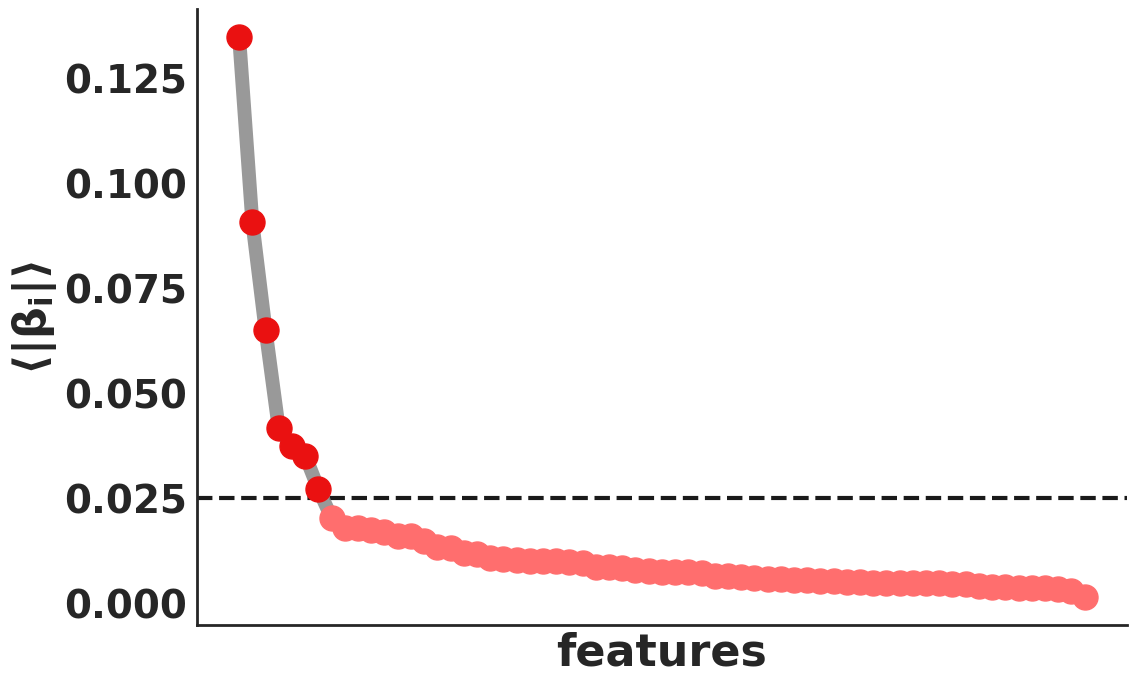

In [44]:
plt.rcParams.update({
    'axes.titlesize': 16,
    'axes.labelsize': 32,
    'xtick.labelsize': 28,
    'ytick.labelsize': 28
})

sns.set_style('white')

plt.figure(figsize=(12,8))

ax = plt.subplot(1, 1, 1)

ax.plot(coefs_nonzero.abs().sort_values(ascending=False), lw=10, zorder=10, c='Gray', alpha=0.8)

ax.plot(coefs_nonzero.abs().sort_values(ascending=False).loc[coefs_nonzero.index[coefs_nonzero.abs()>=0.022]],
        'o', ms=18, zorder=100, c='#EA1111')
ax.plot(coefs_nonzero.abs().sort_values(ascending=False).loc[coefs_nonzero.index[coefs_nonzero.abs()<0.022]],
        'o', ms=18, zorder=100, c='#FF6E6E')
ax.axhline(0.025, ls='--', lw=3, c='k', zorder=1)
ax.set_ylabel('$\\rm \\bf \\langle | \\beta_{i} | \\rangle$')
ax.set_xlabel('features')
ax.set_xticks([])
ax.set_xticklabels([])
for axis in ['top','bottom','left','right']:
    if axis in ['top', 'right']:
        ax.spines[axis].set_visible(False)
    ax.spines[axis].set_linewidth(2)
plt.savefig(os.path.join(pltdir, 'feature_selection_curve.png'), dpi=300, bbox_inches = 'tight')
plt.show()


In [22]:
features = coef_sorted.loc[coefs_nonzero.index[coefs_nonzero.abs()>=0.025]].index
features

Index(['v10-v82', 'v12-v13', 'v14-v65', 'v145-v152', 'e12-e21', 'e145-e153',
       'e44-e56'],
      dtype='object', name='res_pair')

In [21]:
format_names = ['$\\rm \\bf elec\ 12_{A}-21_{A}$', '$\\rm \\bf vdw\ 12_{A}-13_{A}$', '$\\rm \\bf vdw\ 14_{A}-65_{A}$', '$\\rm \\bf elec\ 46_{B}-54_{B}$', '$\\rm \\bf vdw\ 10_{A}-82_{A}$', '$\\rm \\bf vdw\ 46_{B}-53_{B}$', '$\\rm \\bf elec\ 44_{A}-56_{A}$']

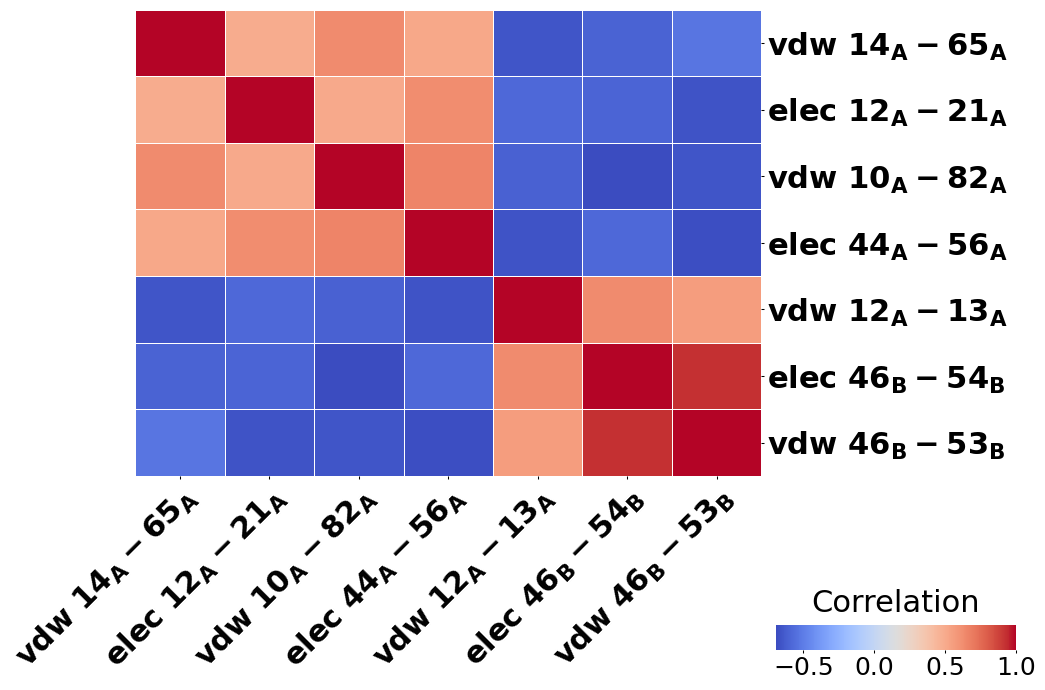

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

x_train = X_train[features]
x_train.columns = format_names
scaler = StandardScaler()
scaler.fit(x_train)

x_train_scale  = pd.DataFrame(scaler.transform(x_train), index=x_train.index, columns=x_train.columns)

# Assume df is your DataFrame with features (without the target variable if it's present)

# Step 1: Compute the correlation matrix
correlation_matrix = x_train_scale.corr()

# Step 2: Create the heatmap
g = sns.clustermap(correlation_matrix, 
               cmap='coolwarm', 
               fmt='.2f', 
               linewidths=0.5, 
               figsize=(12, 10),
               yticklabels=True,
               xticklabels=True,
               cbar_pos=(0.7, 0.2, 0.2, 0.025),  # (x, y, width, height) in figure coordinates
               cbar_kws={
                   'ticks': [-1, -0.5, 0, 0.5, 1],
                   'orientation': 'horizontal'
               },
               method='ward')

# Hide dendrograms
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)

plt.setp(
    g.ax_heatmap.get_xticklabels(),
    weight="normal",
    fontsize=22,
    rotation=45,
    ha="right",             # Align the end of text with the tick
    rotation_mode="anchor"  # Anchor rotation around the text position
)

plt.setp(g.ax_heatmap.get_yticklabels(), fontsize=22)  # Set font size for x-tick labels

# Access the colorbar object
cbar = g.ax_heatmap.collections[0].colorbar

# Style the colorbar title and tick labels
cbar.ax.set_title('Correlation', fontweight='normal', fontsize=22, pad=10, loc='center')

for label in cbar.ax.get_xticklabels():
    label.set_fontweight('normal')
    label.set_fontsize(18)


plt.savefig(os.path.join(pltdir, 'feature_correlation_matrix.png'), dpi=300, bbox_inches = 'tight')

    
# Step 3: Add the title and show the plot
#plt.title('Clustered Feature Correlation Heatmap')
plt.show()

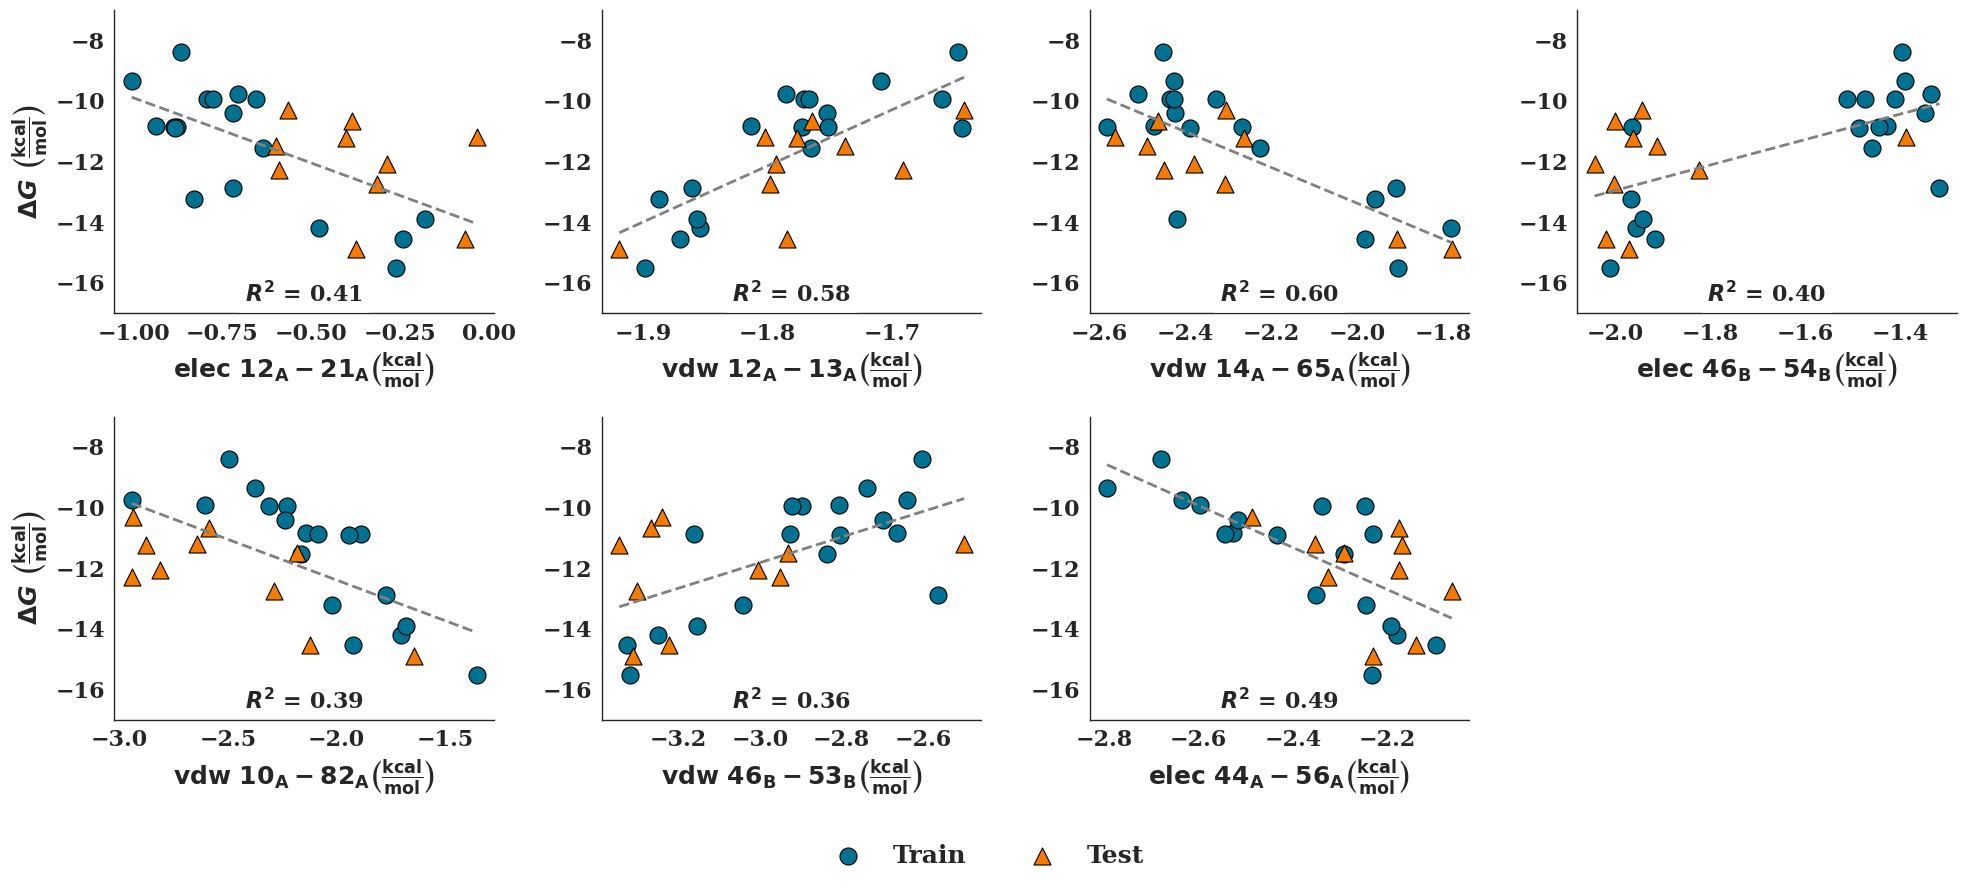

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import linregress

sns.set(context='paper', style='white')

# Set matplotlib defaults for publication-quality figures
plt.rcParams.update({
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'font.family': 'serif',
    'axes.labelweight': 'bold',
    'axes.titlesize': 18,
    'legend.fontsize': 10,
    'figure.figsize': (10, 8),
    'font.weight': 'bold'
})

feat_to_plot = features

# Number of subplots
num_plots = len(feat_to_plot)
cols = 4
rows = int(np.ceil(num_plots / cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4.2))
axes = axes.flatten()

# Marker and color settings
marker_map = {0: 'o', 1: '^'}  # 0: train, 1: test
color_map = {0: '#007191', 1: '#f47a00'}  # Blue and orange for visual contrast
label_map = {0: 'Train', 1: 'Test'}


#y_titles = ['elec 12-21', 'vdW 14-65', 'vdW 10-82', 'elec 44-56']
y_titles = format_names

for i, col in enumerate(feat_to_plot):
    ax = axes[i]
    for testset_value in [0, 1]:
        subset = XY[XY['testset'] == testset_value]
        ax.scatter(
            subset[col],
            subset['dG (kcal/mol)'],
            marker=marker_map[testset_value],
            color=color_map[testset_value],
            edgecolor='black',
            s=150,
            label=label_map[testset_value] if i == 0 else None  # Only label once
        )
    
    # Regression line (fit to all data)
    x = XY[col]
    y = XY['dG (kcal/mol)']
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    x_vals = np.linspace(x.min(), x.max(), 100)
    y_vals = slope * x_vals + intercept
    ax.plot(x_vals, y_vals, color='gray', linestyle='--', linewidth=2)
    

    ax.set_xlabel(str(y_titles[i])+r"$\left(\frac{\mathrm{kcal}}{\mathrm{mol}}\right)$", fontsize=18)  # Set y-axis title from the list based on index

    if i % cols == 0:  # First column
        ax.set_ylabel(r"$\Delta G\ \left(\frac{\mathrm{kcal}}{\mathrm{mol}}\right)$", fontsize=18)

    ax.set_ylim(-17, -7)  # Replace with your desired limits

    # Set y-tick locations
    desired_ticks = [-16, -14, -12, -10, -8]  # example values
    ax.set_yticks(desired_ticks, weight="bold")

    # Hide the top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Optionally, make sure bottom and left spines are visible (they are by default)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)

    ax.text(
    0.5, 0.02,  # x=center, y=near bottom
    f"$R^2$ = {r_value**2:.2f}",
    transform=ax.transAxes,
    fontsize=16,
    verticalalignment='bottom',
    horizontalalignment='center',  # Center the text horizontally
    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
   

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Global legend at top
handles, labels = axes[0].get_legend_handles_labels()

fig.legend(handles, labels,
           loc='lower center',
           bbox_to_anchor=(0.5, -0.08),
           ncol=2, frameon=False, fontsize=18)
fig.subplots_adjust(bottom=0.2)  # Increase bottom margin to make room for the legend

# Layout spacing
plt.tight_layout(pad=2)#, rect=[0, 0, 1, 0.95])

plt.savefig(os.path.join(pltdir, 'features_vs_dg.png'), dpi=300, bbox_inches = 'tight')

plt.show()


In [29]:
from itertools import combinations

pred_coef = list(features)
results_df = pd.DataFrame(columns=pred_coef+['rsquared', 'aic'])
r_min = 1
r_max = 7
i = 0

for r in range(r_min, r_max+1):
    for c in combinations(pred_coef, r):
        x_eval = StandardScaler().fit_transform(X_train[list(c)])
        m = sm.OLS(y_train, sm.add_constant(x_eval)).fit()

        # Predict on training data
        y_train_pred = m.predict(sm.add_constant(x_eval))  # <-- add this line

        results_df.loc[i, list(c)] = True
        results_df.loc[i, 'rsquared'] = m.rsquared
        results_df.loc[i, 'pearson'] = pearsonr(y_train, y_train_pred)[0]  # <-- now correct
        results_df.loc[i, 'spearman'] = spearmanr(y_train, y_train_pred)[0]  # <-- now correct
        results_df.loc[i, 'rmse_train'] = np.sqrt(mean_squared_error(y_train, y_train_pred))
        results_df.loc[i, 'aic'] = m.aic
        results_df.loc[i, 'df'] = m.df_model

        # Predict on test data
        X_test_scaled = StandardScaler().fit_transform(X_test[list(c)])
        y_test_pred = m.predict(sm.add_constant(X_test_scaled))

        from sklearn.metrics import r2_score, mean_squared_error
        results_df.loc[i, 'rsquared_test'] = r2_score(y_test, y_test_pred)
        results_df.loc[i, 'rmse_test'] = np.sqrt(mean_squared_error(y_test, y_test_pred))
        results_df.loc[i, 'pearson_test'] = pearsonr(y_test, y_test_pred)[0]
 
        i += 1
        
relative_likelihood = lambda x, x_min: np.exp((x_min-x)/2)
aic_min = results_df.aic.min()
for index, aic in zip(results_df.index, results_df.aic):
    results_df.loc[index, 'rlh'] = relative_likelihood(aic, aic_min)

print(results_df[(results_df.rlh>0.05)].sort_values('rsquared', ascending=False)[:5])
#print(results_df[(results_df.rlh>0.05) & (results_df.df<=4)].sort_values('rsquared_test', ascending=False))

    v10-v82 v12-v13 v14-v65 v145-v152 e12-e21 e145-e153 e44-e56  rsquared  \
126    True    True    True      True    True      True    True  0.956287   
120    True    True    True      True    True       NaN    True  0.956255   
122    True    True    True       NaN    True      True    True  0.955979   
102    True    True    True       NaN    True       NaN    True   0.95554   
119    True    True    True      True    True      True     NaN  0.954325   

           aic   pearson  spearman  rmse_train   df  rsquared_test  rmse_test  \
126  35.362462  0.977899  0.908622    0.414330  7.0       0.361817   1.170133   
120  33.375533  0.977883  0.906557    0.414481  6.0       0.358644   1.173039   
122  33.488648  0.977742  0.908622    0.415785  6.0       0.339279   1.190617   
102  31.667446  0.977517  0.908622    0.417855  5.0       0.315476   1.211873   
119  34.152576  0.976896  0.912752    0.423524  6.0       0.325952   1.202564   

     pearson_test       rlh  
126      0.828173  0

In [30]:
print(results_df[(results_df.df==4)].sort_values('rsquared', ascending=False)[:5])

   v10-v82 v12-v13 v14-v65 v145-v152 e12-e21 e145-e153 e44-e56  rsquared  \
64    True    True    True       NaN    True       NaN     NaN  0.953231   
67    True    True     NaN      True    True       NaN     NaN  0.930801   
70    True    True     NaN       NaN    True      True     NaN   0.93013   
71    True    True     NaN       NaN    True       NaN    True  0.929724   
77    True     NaN    True       NaN    True       NaN    True  0.929008   

          aic   pearson  spearman  rmse_train   df  rsquared_test  rmse_test  \
64  30.578691  0.976336  0.923077    0.428567  4.0       0.283554   1.239808   
67  37.630492  0.964780  0.916882    0.521302  4.0       0.210999   1.301072   
70  37.804214  0.964432  0.916882    0.523824  4.0       0.176650   1.329092   
71  37.908572  0.964222  0.927207    0.525345  4.0       0.113357   1.379232   
77  38.090923  0.963851  0.935467    0.528013  4.0       0.426262   1.109480   

    pearson_test       rlh  
64      0.813930  1.000000  
67  

0 0.7983110803828365 0.7983110803828365
1 0.4999777630332923 0.6491444217080644
2 0.6205931899300317 0.6396273444487202
3 0.49817524984696 0.6042643207982801
4 1.0687206732285168 0.6971555912843275


/tmp/ipykernel_281455/1903267975.py:12: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions = pd.Series(index=y_train.index)


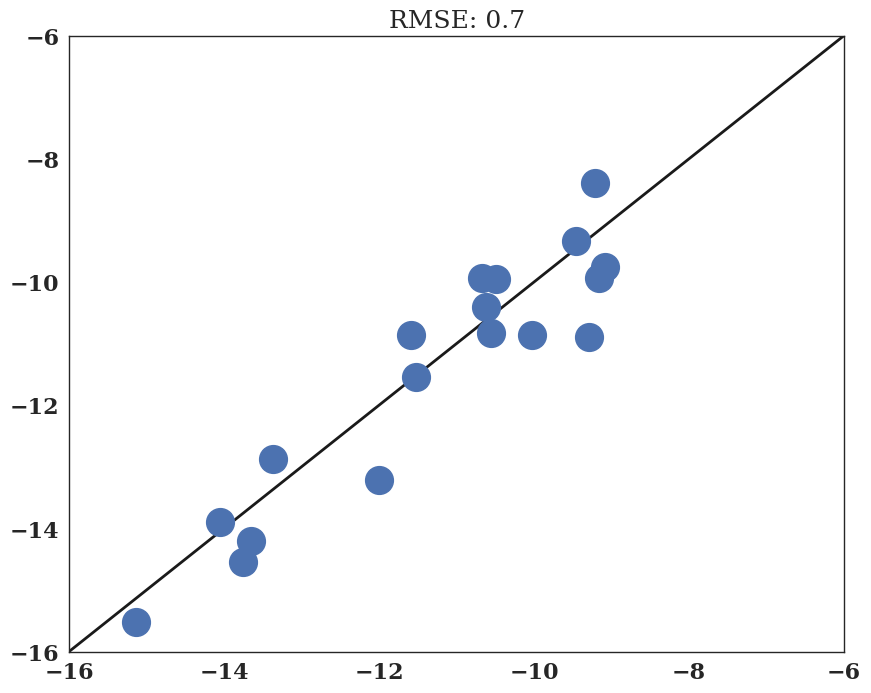

In [31]:
final_features = ['e12-e21', 'v12-v13', 'v14-v65', 'v10-v82']

x = X[final_features]
x_train = x.loc[y_train.index]
x_test = x.loc[y_test.index]

cv =KFold(n_splits=5)
clf = Pipeline([('scale', StandardScaler()),
                ('ols', LinearRegression())])

mse = []
predictions = pd.Series(index=y_train.index)
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    for i,(tindex, vindex) in enumerate(cv.split(x_train)):
        Xt, Xv, yt, yv = x_train.iloc[tindex], x_train.iloc[vindex], y_train.iloc[tindex], y_train.iloc[vindex]
        clf.fit(Xt, yt)
        yv_hat = clf.predict(Xv)
        predictions.iloc[vindex] = yv_hat
        mse.append(mean_squared_error(yv_hat, yv))
        print(i,np.sqrt(mse[-1]), np.mean(np.sqrt(mse)))

plt.plot(predictions, y_train, 'o', ms=20, zorder=10)
plt.title('RMSE: {:.1f}'.format(np.mean(np.sqrt(mse))))
lim = (-16, -6)
plt.xlim(lim)
plt.ylim(lim)
plt.plot(lim, lim, lw=2, c='k', zorder=1)

In [32]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scale  = pd.DataFrame(scaler.transform(x_train), index=x_train.index, columns=x_train.columns)
x_test_scale = pd.DataFrame(scaler.transform(x_test), index=x_test.index, columns=x_test.columns)

m = sm.OLS(y_train, sm.add_constant(x_train_scale)).fit()
m.summary()

/opt/usershared/software/schrodinger25.1/internal/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=18 observations were given.
  return hypotest_fun_in(*args, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          dG (kcal/mol)   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     66.24
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           1.63e-08
Time:                        12:56:52   Log-Likelihood:                -10.289
No. Observations:                  18   AIC:                             30.58
Df Residuals:                      13   BIC:                             35.03
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.4991      0.119    -96.742      0.000     -11.756     -11.242
e12-e21       -0.6844      0.166     -4.135      0.001      -1.042      -0.327
v12-v13        0.5575      0.177      3.149      0.008       0.175       0.940
v14-v65       -0.4500      0.171     -2.624      0.021      -0.820      -0.080
v10-v82       -0.6476      0.151     -4.275      0.001      -0.975      -0.320
==============================================================================
Omnibus:                        0.900   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.638   Jarque-Bera (JB):                0.734
Skew:                          -0.140   Prob(JB):                        0.693
Kurtosis:                       2.051   Cond. No.                         2.91
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
def plot_ols(model, x, y, **kwargs):
    yhat = m.predict(sm.add_constant(x))
    yerr1 = ((sm.add_constant(x)@m.conf_int()[0].values) - yhat).values
    yerr2 = ((sm.add_constant(x)@m.conf_int()[1].values) - yhat).values
    yerr = np.zeros((2, len(y)))

    # matplotlib errorbar takes only positive values
    for i,(e1, e2) in enumerate(zip(yerr1, yerr2)):
        if e1 >= 0 :
            yerr[1][i] = e1
        else:
            yerr[0][i] = np.abs(e1)
        if e2 >= 0 :
            yerr[1][i] = e2
        else:
            yerr[0][i] = np.abs(e2)
    return  plt.errorbar(y, yhat, yerr=yerr, **kwargs)

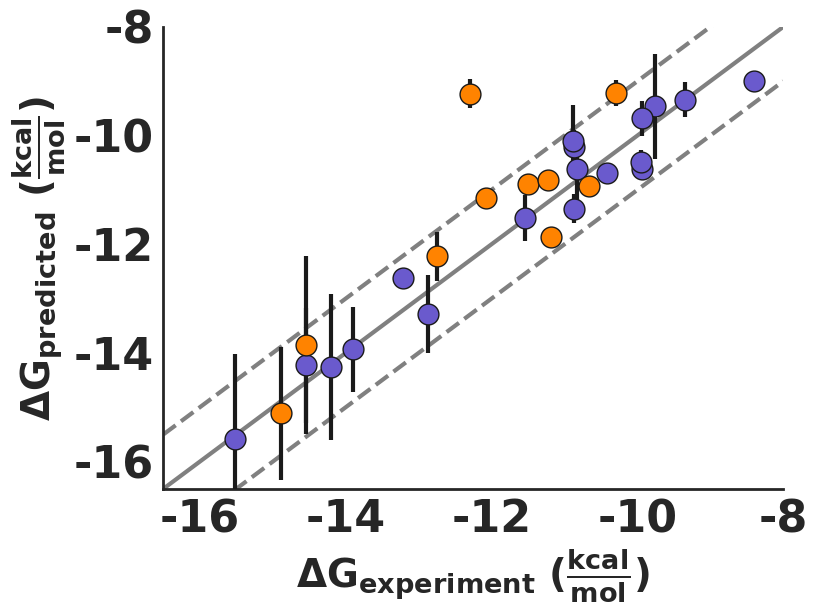

In [45]:
plt.rcParams.update({
    'font.size': 14,          # base font size
    'axes.titlesize': 32,     # title font size
    'axes.labelsize': 28,     # x and y axis labels
    'xtick.labelsize': 32,    # x tick labels
    'ytick.labelsize': 32,    # y tick labels
    'legend.fontsize': 32,    # legend font size
})

sns.set_style("white")
lim = np.array([-16.5, -8])

plt.figure(figsize=(8, 6))

ax = plt.subplot(1, 1, 1)

e1 = plot_ols(m, x_train_scale, y_train, fmt='o', ms=15, lw=3, c='#6A5ACD', markeredgecolor='k', ecolor='k',
              label='train', zorder=100)
e2 = plot_ols(m, x_test_scale, y_test, fmt='o', ms=15, lw=3, c='#FF8300', markeredgecolor='k', ecolor='k',
              label='test', zorder=100)

plt.plot(lim, lim, lw=3, ls='-', c='Gray', zorder=1)
plt.plot(lim, lim+np.ones(2), lw=3, ls='--', c='Gray', zorder=1)
plt.plot(lim, lim-np.ones(2), lw=3, ls='--', c='Gray', zorder=1)
plt.xlim(lim)
plt.xlabel('$\\rm \\bf \\Delta G_{experiment}\ (\\frac{kcal}{mol})$')
plt.ylabel('$\\rm \\bf \\Delta G_{predicted}\ (\\frac{kcal}{mol})$')

for axis in ['top','bottom','left','right']:
    if axis in ['top', 'right']:
        ax.spines[axis].set_visible(False)
    ax.spines[axis].set_linewidth(2)

plt.xticks(list(range(-16, -6, 2)), list(map(str, list(range(-16, -6, 2)))))
plt.yticks(list(range(-16, -6, 2)), list(map(str, list(range(-16, -6, 2)))))
plt.ylim(lim)
plt.xlim(lim)
#plt.legend(bbox_to_anchor=(0.5, -0.35), loc='center', borderaxespad=0., ncol=2)
#plt.title('Sparse Model')
plt.savefig(os.path.join(pltdir, 'regression_model.png'), dpi=600, bbox_inches = 'tight')
plt.show()

### Training results

In [35]:
print("RMSE:  " + str(np.mean(np.sqrt(mse))))
print(pearsonr(predictions, y_train))
print(spearmanr(predictions, y_train))

RMSE:  0.6971555912843275
PearsonRResult(statistic=0.9368904780249344, pvalue=1.0368238524788696e-08)
SignificanceResult(statistic=0.8683532391063595, pvalue=2.9769980440599985e-06)


In [38]:
# Get the stats for each row
predictions = m.get_prediction(sm.add_constant(x_train_scale))

# Store in a DataFrame with the original index
results_df = pd.DataFrame({
    'Actual dG': y_train.values,
    'Predicted dG': predictions.predicted_mean,
    'Residual': y_train.values - predictions.predicted_mean,
    'SE': predictions.se_mean,                  
    'Lower CI': predictions.conf_int()[:, 0],  
    'Upper CI': predictions.conf_int()[:, 1]   
}, index=y_train.index)  # Add the index here!

#results_df

### Test results

In [39]:
yhat = m.predict(sm.add_constant(x_test_scale))
print("RMSE:  " + str(np.sqrt(mean_squared_error(yhat, y_test))))
print(pearsonr(yhat, y_test))
print(spearmanr(yhat, y_test))

RMSE:  1.1520120766062056
PearsonRResult(statistic=0.831817291377114, pvalue=0.0028421743874538327)
SignificanceResult(statistic=0.6848484848484848, pvalue=0.02888279750673276)


In [40]:
# Get the stats for each row
predictions = m.get_prediction(sm.add_constant(x_test_scale))

# Store in a DataFrame with the original index
results_df = pd.DataFrame({
    'Actual dG': y_test.values,
    'Predicted dG': predictions.predicted_mean,
    'Residual': y_test.values - predictions.predicted_mean,
    'SE': predictions.se_mean,                  
    'Lower CI': predictions.conf_int()[:, 0],  
    'Upper CI': predictions.conf_int()[:, 1]   
}, index=y_test.index)  # Add the index here!

#results_df

,Actual dG,Predicted dG,Residual,SE,Lower CI,Upper CI
name,,,,,,
19_DRV_var18,-12.290,-9.226614,-3.063386,0.385023,-10.058405,-8.394823
20_DRV_var19,-11.497,-10.885934,-0.611066,0.202384,-11.323160,-10.448709
21_DRV_3EKT,-14.540,-13.858574,-0.681426,0.465998,-14.865302,-12.851847
22_DRV_var21,-11.190,-11.864238,0.674238,0.556136,-13.065696,-10.662780
23_DRV_var22,-14.889,-15.113329,0.224329,0.280396,-15.719089,-14.507570
24_DRV_var23,-11.220,-10.817264,-0.402736,0.442925,-11.774146,-9.860382
25_DRV_var24,-10.660,-10.936794,0.276794,0.340521,-11.672444,-10.201143
26_DRV_var25,-10.300,-9.218405,-1.081595,0.469468,-10.232629,-8.204181
27_DRV_5KQY,-12.750,-12.224756,-0.525244,0.287382,-12.845608,-11.603904
